### Import packages

In [1]:
from swat import *
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [5]:
cashost='eeclxvm128b.unx.sas.com'
casport=5570
casauth='/home/sasdemo/.authinfo'

### Start CAS session

In [6]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

### Details for local data to be loaded into CAS

In [7]:
indata_dir="/opt/sasinside/DemoData"
indata="bank"
target = "b_tgt"

### Import table action set

In [21]:
sess.loadactionset(actionset="table")
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'table'.
NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000124s, sys: 0.001s, mem: 0.0283mb

### Load data into CAS

In [22]:
if not sess.table.tableExists(table=indata).exists:
    tbl = sess.upload_file(indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the uploaded file available as table BANK in caslib CASUSER(viyauser).
NOTE: The table BANK has been created in caslib CASUSER(viyauser) from binary data uploaded to Cloud Analytic Services.


### Partition the data into training and validation

In [23]:
sess.sampling.stratified(
  table={"name":"bank", "groupBy":target},
  output={"casOut":{"name":"bank_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=2010621402 for sampling.


[outputSize]

 {'outputNObs': 1060038.0, 'outputNVars': 55}

[STRAFreq]

 Frequencies
 
    ByGrpID         b_tgt    NObs   NSamp
 0        0             0  848529  593970
 1        1             1  211509  148056

[OutputCasTables]

               casLib       Name Label     Rows  Columns  \
 0  CASUSER(viyauser)  bank_part        1060038       55   
 
                                             casTable  
 0  CASTable('bank_part', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.985s, user: 3.21s, sys: 0.838s, mem: 49.4mb

### Random Forest Predictive Model

In [24]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"bank_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs={'cat_input1', 'cat_input2', 'logi_rfm1', 'logi_rfm2', 'logi_rfm3', 'logi_rfm4', 'logi_rfm5',
         'logi_rfm6', 'logi_rfm7', 'logi_rfm8', 'logi_rfm9', 'logi_rfm10', 'logi_rfm11', 'logi_rfm12'},
  nominals={'b_tgt', 'cat_input1', 'cat_input2'},
  target="b_tgt",
  nTree=20,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAIN",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  OOB=True,
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"bank_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"b_tgt", "_partind_"},
  vote="PROB"
)

# Create p_b_tgt0 and p_b_tgt1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_b_tgt1=_rf_predp_; 
    p_b_tgt0=1-p_b_tgt1; end; if _rf_predname_=0 then do; p_b_tgt0=_rf_predp_; p_b_tgt1=1-p_b_tgt0; end; run;"""
)

Forest for BANK_PART 
 Descr 
 Value 
 
 
 Number of Trees 20 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 14 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 34455 
 Min Number of Tree Nodes 30897 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 21 
 Max Number of Leaves 17228 
 Min Number of Leaves 15449 
 Maximum Size of Leaves 14360 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 10.440469741 
 
 
 
 
 OOB Error With Forest Analytics for BANK_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 16723 0.1397107316 0.5998532902 0.1004166261 0.316885825 1 
 1 2 33006 0.1337151661 0.7315943938 0.1804531805 0.4247978113 1 
 2 3 49866 0.1270876987 0.7894221496 0.2246384031 0.4739603391 1 
 3 4 66326 0.1222447301 0.8174030576 0.2522490925 0.5022440567 1 
 4 5 81775 0.1183526424 0.8297599209 0.2702711225 0.5198760645 1 
 5 6 97871 0.1153095483 0.8399193629 0.2823776839 0.5313922129 1 
 6 7 114426 0.1125562117 0.8446933636 0.2906597203 0.5391286677 1 
 7 8 131079 0.1109349017 0.8489008319 0.2967471231 0.5447450074 1 
 8 9 147683 0.1092499103 0.8517235198 0.3010687166 0.5486972905 1 
 9 10 163928 0.1085504716 0.8550376019 0.3045305674 0.5518428829 1 
 10 11 179720 0.1078380757 0.8581409767 0.3073248091 0.5543688385 1 
 11 12 196948 0.10724683 0.8601410405 0.309480443 0.5563096646 1 
 12 13 213165 0.1067772351 0.8623650589 0.311317527 0.557958356 1 
 13 14 229121 0.1062359082 0.8644824812 0.3128173779 0.5593007938 1 
 14 15 245532 0.1056197946 0.8659008454 0.3140315817 0.5603852083 1 
 15 16 262185 0.1053970025 0.8671711148 0.3150999937 0.5613376824 1 
 16 17 278175 0.1051447054 0.8683292733 0.3160637345 0.5621954593 1 
 17 18 293969 0.104881911 0.8695553129 0.316946439 0.5629799632 1 
 18 19 310734 0.1046324522 0.870420703 0.3175962857 0.5635568167 1 
 19 20 326935 0.1044046974 0.8713518073 0.3182117454 0.5641026019 1 
 
 
 
 
 Forest for BANK_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 logi_rfm5 13171.805601 356.18026621 
 logi_rfm9 9092.379572 54.992607379 
 logi_rfm4 8663.0426181 309.70020739 
 logi_rfm1 8558.438296 391.62671649 
 cat_input2 5964.0968583 35.534668301 
 logi_rfm3 5896.4098247 240.70095401 
 logi_rfm8 5163.4571876 14.505484568 
 logi_rfm2 4578.1947133 65.163017827 
 logi_rfm6 4219.2279528 15.70582295 
 logi_rfm11 3647.1116302 9.7357173056 
 logi_rfm12 3603.4821716 2.7950748699 
 logi_rfm7 3431.7597339 10.998811999 
 logi_rfm10 3304.4008963 12.027075316 
 cat_input1 844.75553984 2.4934637999 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) forest_model 653850 38 CASTable('forest_model', caslib='CASUSER(viyauser)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:115
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:115  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,1060038,7,"CASTable('_scored_rf', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,1060038,9,"CASTable('_scored_rf', caslib='CASUSER(viyause..."


### Gradient Boosting

In [25]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"bank_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs={'cat_input1', 'cat_input2', 'logi_rfm1', 'logi_rfm2', 'logi_rfm3', 'logi_rfm4', 'logi_rfm5',
         'logi_rfm6', 'logi_rfm7', 'logi_rfm8', 'logi_rfm9', 'logi_rfm10', 'logi_rfm11', 'logi_rfm12'},
  nominals={'b_tgt', 'cat_input1', 'cat_input2'},
  target="b_tgt",
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"bank_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"b_tgt", "_partind_"}
)

# Create p_b_tgt0 and p_b_tgt1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_b_tgt1=_gbt_predp_; 
    p_b_tgt0=1-p_b_tgt1; end; if _gbt_predname_=0 then do; p_b_tgt0=_gbt_predp_; p_b_tgt1=1-p_b_tgt0; end; run;"""
)

Gradient Boosting Tree for BANK_PART 
 Descr 
 Value 
 
 
 Number of Trees 10 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 14 
 Number of Bins 20 
 Number of Variables 14 
 Max Number of Tree Nodes 63 
 Min Number of Tree Nodes 63 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 32 
 Min Number of Leaves 32 
 Maximum Size of Leaves 127922 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for BANK_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 logi_rfm5 11829.876676 4826.0444636 
 logi_rfm9 3495.6387246 493.57772798 
 logi_rfm2 3177.8576803 1106.0341664 
 cat_input2 1826.5352607 227.06487323 
 logi_rfm4 873.94964966 1102.8866046 
 logi_rfm1 811.38906199 787.83076996 
 logi_rfm3 36.799145193 69.394866268 
 cat_input1 5.2154869787 0 
 logi_rfm6 1.5818202029 0 
 logi_rfm7 0.7668367513 0 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) gb_model 630 28 CASTable('gb_model', caslib='CASUSER(viyauser)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:117
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:117  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_gb,1060038,6,"CASTable('_scored_gb', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_gb,1060038,8,"CASTable('_scored_gb', caslib='CASUSER(viyause..."


### Neural Network

In [26]:
nn = sess.neuralNet.annTrain(
  table={
    "name":"bank_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"bank_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs={'cat_input1', 'cat_input2', 'logi_rfm1', 'logi_rfm2', 'logi_rfm3', 'logi_rfm4', 'logi_rfm5',
         'logi_rfm6', 'logi_rfm7', 'logi_rfm8', 'logi_rfm9', 'logi_rfm10', 'logi_rfm11', 'logi_rfm12'},
  nominals={'b_tgt', 'cat_input1', 'cat_input2'},
  target="b_tgt",
  hiddens={2},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Output model statistics
render_html(nn)

# Score 
sess.neuralNet.annScore(
  table={"name":"bank_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"b_tgt", "_partind_"}
)

# Create p_b_tgt0 and p_b_tgt1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="""data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_b_tgt1=_nn_predp_; 
    p_b_tgt0=1-p_b_tgt1; end; if _nn_predname_=0 then do; p_b_tgt0=_nn_predp_; p_b_tgt1=1-p_b_tgt0; end; run;"""
)

Iteration History 
 Progress 
 Objective 
 Loss 
 Validation Error 
 Step Size 
 L1 Norm 
 L2 Norm 
 MAX Norm 
 Gradient Norm 
 
 
 1 2.7846933858 2.7846933858 0.7951303724 0 1.2176668135 0.2252144134 0.0989984179 1.237116635 
 2 2.0566747218 2.0566747218 0.1995302064 0.8083312209 1.1202467042 0.2108396816 0.0620297479 0.3024484424 
 3 1.9989637461 1.9989637461 0.1995302064 1 1.234031665 0.237412926 0.0916088688 0.0633157033 
 4 1.9935066074 1.9935066074 0.1995302064 1 1.3911531386 0.2716508044 0.1114190028 0.0697632299 
 5 1.9585094047 1.9585094047 0.1995302064 1 4.4207099568 0.9222078456 0.3617870534 0.4189612235 
 6 1.9227413429 1.9227413429 0.1995302064 1 10.171572289 2.0772273927 0.7938421606 0.7486005691 
 7 1.8298359392 1.8298359392 0.1995302064 1 14.47383369 2.8970600462 1.1039096193 0.6347017715 
 8 1.7059428763 1.7059428763 0.1963825264 1 18.092772387 3.5956169578 1.5969459667 0.2770039065 
 9 1.6504428954 1.6504428954 0.1995302064 1 12.16019747 2.4107994461 1.1068492334 0.1801945057 
 10 1.6166277694 1.6166277694 0.1938291637 1 13.73239591 2.7182586812 1.2234411513 0.1151473646 
 11 1.551477755 1.551477755 0.1765845314 1 15.824666668 3.2387351279 1.4656081886 0.1863087037 
 12 1.5157447585 1.5157447585 0.1718803064 1 17.437921072 3.6149129374 1.6189083844 0.1884077772 
 13 1.5058173652 1.5058173652 0.1751097443 1 19.977489057 4.2180134379 1.7698958518 0.3490822693 
 14 1.4784181477 1.4784181477 0.1656101028 1 18.456369066 3.8939701225 1.5955574222 0.07283861 
 15 1.4758559685 1.4758559685 0.1649371722 1 18.261951992 3.870999465 1.5739652091 0.0516730469 
 16 1.4717034533 1.4717034533 0.1634875414 1 18.43487231 3.9409403746 1.57727623 0.0582581582 
 17 1.4667558597 1.4667558597 0.1629435367 1 18.364263824 3.9531511829 1.5702205758 0.0598094726 
 18 1.4653207139 1.4653207139 0.1627076966 1 19.362206657 4.1906064958 1.6492479901 0.0530057371 
 19 1.4628191292 1.4628191292 0.162745431 1 18.345291029 3.975710138 1.564371802 0.0398582218 
 20 1.4610771949 1.4610771949 0.1622045709 1 18.305446448 3.973321718 1.5570856898 0.0347839137 
 21 1.4595786066 1.4595786066 0.161811504 0.4418714493 18.075265487 3.935722597 1.5333967833 0.0531687539 
 22 1.4571676551 1.4571676551 0.1605568343 1 18.085088485 3.9767426185 1.562278864 0.0261530483 
 23 1.4549024828 1.4549024828 0.1598870483 1 18.055264386 4.035069888 1.6497198382 0.0273548017 
 24 1.4530239751 1.4530239751 0.1597801341 1 18.009801986 4.086109398 1.7161363186 0.0217022855 
 25 1.4509391439 1.4509391439 0.1593807781 1 18.086852565 4.2315620683 1.8631962529 0.0260627945 
 26 1.4497246346 1.4497246346 0.159151227 1 18.295915638 4.38247315 2.0088573442 0.0580274677 
 27 1.4489696883 1.4489696883 0.1593839226 1 18.316503091 4.4084696214 2.0358186127 0.0326688533 
 28 1.4478145722 1.4478145722 0.1592644303 1 18.391058603 4.4760678692 2.1116407599 0.0278737641 
 29 1.4473194785 1.4473194785 0.1592675748 1 18.386750029 4.5142249767 2.159675955 0.0275605953 
 30 1.4460063347 1.4460063347 0.1590883363 1 18.518193415 4.6705104135 2.3559976542 0.0357189991 
 31 1.4455848187 1.4455848187 0.1590317347 0.1082323003 18.379043975 4.661660847 2.3758815108 0.0134188982 
 32 1.4454237491 1.4454237491 0.1588462071 1 18.286689816 4.6380729837 2.3635401661 0.0097572923 
 33 1.4451569642 1.4451569642 0.1587172811 1 18.148256039 4.6134600212 2.3597753537 0.0110144036 
 34 1.4448535345 1.4448535345 0.1583179251 1 17.944588763 4.5890206929 2.367644688 0.0095152727 
 35 1.4447646158 1.4447646158 0.1581449757 0.1459339403 17.933675377 4.6021424833 2.3868926537 0.0259020595 
 36 1.4444969871 1.4444969871 0.15791228 1 17.818760281 4.609689497 2.4162888799 0.0174863328 
 37 1.4441711193 1.4441711193 0.1581198194 1 17.809268644 4.6465701205 2.4711927341 0.0103396231 
 38 1.4439174748 1.4439174748 0.1580474951 1 17.863054662 4.6894520191 2.5215016805 0.0106042436 
 39 1.443662915 1.443662915 0.1578053658 1 17.837158337 4.7252352753 2.5679184275 0.0089596093 
 40 1.4435149358 1.4435149358 0.1579908934 1 1

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:115
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:115  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_nn,1060038,4,"CASTable('_scored_nn', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_nn,1060038,6,"CASTable('_scored_nn', caslib='CASUSER(viyause..."


### Support Vector Machine

In [27]:
sv = sess.svm.svmTrain(
  table={
    "name":"bank_part", 
    "where":"_partind_=1"
  },
  inputs={'cat_input1', 'cat_input2', 'logi_rfm1', 'logi_rfm2', 'logi_rfm3', 'logi_rfm4', 'logi_rfm5',
         'logi_rfm6', 'logi_rfm7', 'logi_rfm8', 'logi_rfm9', 'logi_rfm10', 'logi_rfm11', 'logi_rfm12'},
  nominals={'b_tgt', 'cat_input1', 'cat_input2'},
  target="b_tgt",
  kernel="POLYNOMIAL",
  degree=2,
  id={"b_tgt", "_partind_"},
  savestate={"name":"svm_astore_model", "replace":True}
)

# Output model statistics
render_html(sv)

# Score using ASTORE
sess.astore.score(
  table={"name":"bank_part"},
  rstore={"name":"svm_astore_model"},
  out={"name":"_scored_svm", "replace":True}
)

NOTE: SVM training is activated.
NOTE: Wrote 13721 bytes to the savestate file svm_astore_model.


Model Information 
 Descr 
 Value 
 
 
 Task Type C_CLAS 
 Optimization Technique Interior Point 
 Scale YES 
 Kernel Function Polynomial 
 Kernel Degree 2 
 Penalty Method C 
 Penalty Parameter 1 
 Maximum Iterations 25 
 Tolerance 1e-06 
 
 
 
 
 Observations 
 Descr 
 N 
 
 
 Number of Observations Read 742026 
 Number of Observations Used 742026 
 
 
 
 
 Training Results 
 Descr 
 Value 
 
 
 Inner Product of Weights 674.01010402 
 Bias 5.7584992624 
 Total Slack (Constraint Violations) 391323.68565 
 Norm of Longest Vector 9.5953502139 
 Number of Support Vectors 742026 
 Number of Support Vectors on Margin 0 
 Maximum F 7.1394827446 
 Minimum F -14.19137462 
 Number of Effects 14 
 Columns in Data Matrix 20 
 Columns in Kernel Matrix 231 
 
 
 
 
 Iteration History 
 Iteration 
 Complementarity 
 Feasibility 
 
 
 1 1002430.8004 527167944.53 
 2 1281.880088 411886.15305 
 3 471.84065485 131177.08922 
 4 122.65034002 16248.145204 
 5 31.602777428 3937.2392782 
 6 19.557471439 1435.8154194 
 7 4.9561264392 222.47705343 
 8 4.5921673308 143.68552892 
 9 0.9272779155 16.116274742 
 10 0.92547791 6.9223814035 
 11 0.9224101187 6.9565974E-8 
 12 0.3344094354 2.1552618E-8 
 13 0.29962563 1.7429655E-8 
 14 0.2542838388 1.3408903E-8 
 15 0.2110284428 9.009506E-9 
 16 0.2072935628 8.6232235E-9 
 17 0.1907256958 6.5444108E-9 
 18 0.1827004574 5.1473872E-9 
 19 0.151506308 3.7445402E-9 
 20 0.1491485583 3.3530549E-9 
 21 0.1449001159 2.8861458E-9 
 22 0.1365169659 2.1260866E-9 
 23 0.1235701203 1.8367099E-9 
 24 0.1166150812 1.4972399E-9 
 25 0.1098240132 1.1684499E-9 
 
 
 
 
 Misclassification Matrix 
 Observed 
 0 
 1 
 Total 
 
 
 0 566106 27864 593970 
 1 87966 60090 148056 
 Total 654072 87954 742026 
 
 
 
 
 Fit Statistics 
 Statistic 
 Training 
 
 
 Accuracy 0.8439003485 
 Error 0.1560996515 
 Sensitivity 0.9530885398 
 Specificity 0.4058599449

,Task,Seconds,Percent
0,Loading the Store,0.000013,0.000010
1,Creating the State,0.002458,0.001872
2,Scoring,1.310278,0.998117
3,Total,1.312750,1.000000


### Assess Models

In [28]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_b_tgt1"}],      
      response="b_tgt",
      event="1",
      pVar={"p_b_tgt0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

svmAssess=assess_model(prefix="svm")    
svm_fitstat =svmAssess.FitStat
svm_rocinfo =svmAssess.ROCInfo
svm_liftinfo=svmAssess.LIFTInfo

### Create ROC and Lift plots (using Validation data)

In [29]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"
svm_liftinfo["model"]="SVM"
svm_rocinfo["model"]="SVM"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(nn_liftinfo, ignore_index=True) \
    .append(svm_liftinfo, ignore_index=True)  
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(nn_rocinfo, ignore_index=True) \
    .append(svm_rocinfo, ignore_index=True) 

#### Print AUC (Area Under the ROC Curve)

In [30]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.933065
300,SVM,0.850977
200,NeuralNetwork,0.847319
100,GradientBoosting,0.846202


#### Draw ROC and Lift plots

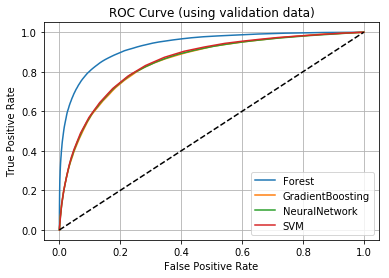

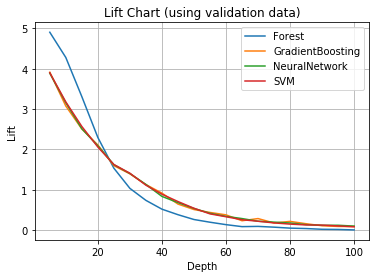

In [31]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [32]:
sess.close()